In [290]:
import pandas as pd
from sklearn.utils import resample
import numpy as np
from xgboost import XGBRegressor
from scipy.stats import norm
import json
import ace_tools_open as tools

FEATURE_COLS = [
    'pitch_count', 'num_pitch_types', 'max_inning',
    'rest_days', 'rolling_K_avg_3', 'rolling_K_avg_5',
    'rolling_pitch_count_5', 'rolling_K_rate',
    'opponent_k_pct', 'park_factor_K', 'whiff_rate',
    'csw_pct', 'whiff_rate_expanding', 'csw_pct_expanding'
]
TARGET_COL = 'strikeouts'
TRAIN_SEASONS = [2021, 2022, 2023, 2024]
TEST_SEASON = 2025

In [291]:
train_dfs = [
    pd.read_parquet(f"../data/processed/pitcher_game_data_{yr}.parquet")
    for yr in TRAIN_SEASONS
]
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.read_parquet(f"../data/processed/pitcher_game_data_{TEST_SEASON}.parquet")

X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]
X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGET_COL]


In [292]:
n_models = 100
ensemble_models = []
ensemble_preds = []

for i in range(n_models):
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=np.random.randint(10_000))
    model = XGBRegressor(objective='count:poisson', verbosity=0,
                         n_estimators=300, max_depth=3, learning_rate=0.1)
    model.fit(X_resampled, y_resampled)
    ensemble_models.append(model)
    ensemble_preds.append(model.predict(X_test))

In [293]:
pred_array = np.vstack(ensemble_preds)
pred_mean = pred_array.mean(axis=0)
pred_std = pred_array.std(axis=0)

results_df = pd.DataFrame({
    "Pred_Mean": pred_mean,
    "Pred_Std": pred_std,
    "Actual": y_test.values,
})

In [294]:
# Add residuals to results_df
results_df['pitcher_name'] = test_df['pitcher_name'].values
results_df['residual'] = results_df['Actual'] - results_df['Pred_Mean']

# Compute residual std per pitcher (can fallback to global mean if sample too small)
resid_std_by_pitcher = results_df.groupby('pitcher_name')['residual'].std().rename('residual_std').reset_index()

In [295]:
def simulate_ev(pred_mean, pred_std, line, over_odds, under_odds, n=10_000):
    """
    Simulate EV for a prop bet line.

    Args:
        pred_mean (float): model predicted mean
        pred_std (float): model std deviation
        line (float): sportsbook line
        over_odds (int): American odds for over
        under_odds (int): American odds for under
        n (int): number of samples

    Returns:
        dict: {expected_value, over_pct, under_pct}
    """
    samples = np.random.normal(loc=pred_mean, scale=pred_std, size=n)

    over_pct = np.mean(samples > line)
    under_pct = 1 - over_pct

    def to_decimal(odds):
        return 1 + (odds / 100) if odds > 0 else 1 + (100 / abs(odds))

    ev = over_pct * to_decimal(over_odds) - 1 if over_pct > 0.5 else under_pct * to_decimal(under_odds) - 1
    return {
        "EV": ev,
        "Over %": over_pct,
        "Under %": under_pct,
    }

In [296]:
lines = pd.read_csv("../data/lines/strikeouts_2025-06-08.csv")
probables = lines['player'].unique().tolist()
print(probables, len(probables))

['Drew Rasmussen', 'Anthony Veneziano', 'Freddy Peralta', 'Ryan Bergert', 'Paul Skenes', 'Cristopher Sánchez', 'Trevor Williams', 'Jack Flaherty', 'Cade Horton', 'Tanner Bibee', 'Brandon Walter', 'Zac Gallen', 'Brady Singer', 'Bowden Francis', 'Joe Ryan', 'Michael Lorenzen', 'Clayton Kershaw', 'Michael McGreevy', 'Tylor Megill', 'Chase Dollander', 'Spencer Strider', 'Landen Roupp', 'Tomoyuki Sugano', 'Tyler Anderson', 'George Kirby', 'Carlos Rodón', 'Hunter Dobbins'] 27


In [297]:
# Load latest pitcher data
df_2025 = pd.read_parquet("../data/processed/pitcher_game_data_2025.parquet")
df_latest = (
    df_2025[df_2025['pitcher_name'].isin(probables)]
    .sort_values(["pitcher_name", 'game_date'])
    .groupby("pitcher_name")
    .tail(1)
    .reset_index(drop=True)
)

with open("../models/XGB_Tuned.json") as f:
    meta = json.load(f)

X_today = df_latest[meta["features"]]
df_latest.head(25)

,pitcher,game_date,pitch_count,strikeouts,max_inning,num_pitch_types,home_team,away_team,rest_days,pitcher_team,...,whiff_rate_expanding,csw_pct_expanding,opponent_k_pct,park_factor_K,rolling_K_avg_3,rolling_K_avg_5,rolling_pitch_count_5,rolling_K_rate,pitcher_name,pitcher_id
0,670102,2025-06-03,58,2,2,4,TOR,PHI,7,TOR,...,0.103720,0.261556,0.202274,0.975952,5.333333,4.6,83.0,0.038554,Bowden Francis,670102
1,663903,2025-06-02,97,4,5,5,CIN,MIL,6,CIN,...,0.079397,0.262312,0.210327,1.002999,3.333333,2.6,88.8,0.022523,Brady Singer,663903
2,477132,2025-06-03,92,2,5,4,LAD,NYM,6,LAD,...,0.083636,0.250909,0.204082,0.926134,2.000000,5.0,85.0,0.055000,Clayton Kershaw,477132
3,656876,2025-06-03,79,8,5,5,TB,TEX,6,TB,...,0.090173,0.265896,0.228688,1.013435,4.333333,3.6,77.8,0.033419,Drew Rasmussen,656876
4,642547,2025-06-03,103,9,7,4,CIN,MIL,6,MIL,...,0.131190,0.265856,0.237075,1.002999,4.666667,5.0,96.6,0.028986,Freddy Peralta,642547
5,656427,2025-06-02,99,4,6,5,CHW,DET,6,DET,...,0.113813,0.294747,0.233631,0.931983,7.333333,6.8,91.8,0.047930,Jack Flaherty,656427
6,657746,2025-06-02,97,4,5,5,ATH,MIN,6,MIN,...,0.123246,0.272545,0.212034,0.970445,6.000000,6.6,88.2,0.040816,Joe Ryan,657746
7,694738,2025-06-03,92,5,7,4,SF,SD,6,SF,...,0.108398,0.294922,0.186011,0.960507,4.666667,4.2,80.2,0.034913,Landen Roupp,694738
8,547179,2025-06-03,74,2,3,7,STL,KC,8,KC,...,0.101010,0.258953,0.206449,0.878779,3.666667,4.6,91.6,0.024017,Michael Lorenzen,547179
9,675911,2025-06-03,85,4,5,4,ATL,ARI,7,ATL,...,0.132565,0.265130,0.196302,1.08805,4.666667,5.0,85.0,0.055000,Spencer Strider,675911


In [298]:
# Predict each model in the ensemble
preds = np.stack([model.predict(X_today) for model in ensemble_models])

df_latest['k_pred_mean'] = preds.mean(axis=0)
df_latest['k_pred_std'] = preds.std(axis=0)
min_std = 0.75
df_latest['k_pred_std'] = np.clip(df_latest['k_pred_std'], min_std, None)

merged = df_latest.merge(lines, left_on='pitcher_name', right_on='player', how='inner')
merged = merged.merge(resid_std_by_pitcher, on='pitcher_name', how='left')

# Fallback for pitchers with no residual std (e.g., rookies)
global_resid_std = results_df['residual'].std()
merged['residual_std'] = merged['residual_std'].fillna(global_resid_std)

merged['hybrid_std'] = np.sqrt(merged['k_pred_std']**2 + merged['residual_std']**2)

# Compute probabilities using normal distribution assumption
merged['p_over'] = 1 - norm.cdf(merged['k_line'], loc=merged['k_pred_mean'], scale=merged['hybrid_std'])
merged['p_under'] = norm.cdf(merged['k_line'], loc=merged['k_pred_mean'], scale=merged['hybrid_std'])

# Convert odds to implied payouts
merged['payout_over'] = merged['over_american_price'].apply(
    lambda x: (x / 100 + 1) if x > 0 else (100 / abs(x) + 1)
)
merged['payout_under'] = merged['under_american_price'].apply(
    lambda x: (x / 100 + 1) if x > 0 else (100 / abs(x) + 1)
)

# Calculate Expected Value
merged['ev_over'] = merged['p_over'] * merged['payout_over'] - (1 - merged['p_over'])
merged['ev_under'] = merged['p_under'] * merged['payout_under'] - (1 - merged['p_under'])

best_ev = merged[['pitcher_name', 'k_line', 'k_pred_mean', 'hybrid_std',
                  'over_american_price', 'p_over', 'ev_over',
                  'under_american_price', 'p_under', 'ev_under']].sort_values(by='ev_over', ascending=False)

tools.display_dataframe_to_user(name="Expected Value Bets", dataframe=best_ev)

Expected Value Bets


Loading ITables v2.4.0 from the internet... (need help?)


In [299]:
def simulate_strikeouts(mean, std, n=10_000):
    draws = np.random.normal(loc=mean, scale=std, size=n)
    return np.round(np.clip(draws, 0, None))

def estimate_probabilities(simulations, k_line):
    over_prob = np.mean(simulations > k_line)
    under_prob = 1 - over_prob
    return over_prob, under_prob

In [300]:
n_sim = 10_000
probs = []

for _, row in merged.iterrows():
    sims = simulate_strikeouts(row['k_pred_mean'], row['hybrid_std'], n=n_sim)
    p_over, p_under = estimate_probabilities(sims, row['k_line'])
    probs.append((p_over, p_under))

merged['mc_p_over'], merged['mc_p_under'] = zip(*probs)

def soften(p, factor=0.85):
    return 0.5 + (p - 0.5) * factor
merged['mc_p_over'] = merged['mc_p_over'].apply(lambda p: soften(p))
merged['mc_p_under'] = 1 - merged['mc_p_over']

merged['mc_ev_over'] = merged['mc_p_over'] * merged['payout_over'] - (1 - merged['mc_p_over'])
merged['mc_ev_under'] = merged['mc_p_under'] * merged['payout_under'] - (1 - merged['mc_p_under'])

In [301]:
mc_ev_df = merged[['pitcher_name', 'k_line', 'k_pred_mean', 'hybrid_std',
                   'over_american_price', 'mc_p_over', 'mc_ev_over',
                   'under_american_price', 'mc_p_under', 'mc_ev_under']
                 ].sort_values(by='mc_ev_over', ascending=False)

tools.display_dataframe_to_user("Monte Carlo EV Bets", mc_ev_df)

Monte Carlo EV Bets


Loading ITables v2.4.0 from the internet... (need help?)


In [302]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style
sns.set_theme(style="whitegrid")
colors = sns.color_palette("Set2")

# Helper function to annotate bars
def annotate_bars(ax, fmt="{:.2f}"):
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.01, p.get_y() + p.get_height() / 2,
                fmt.format(width), va='center')


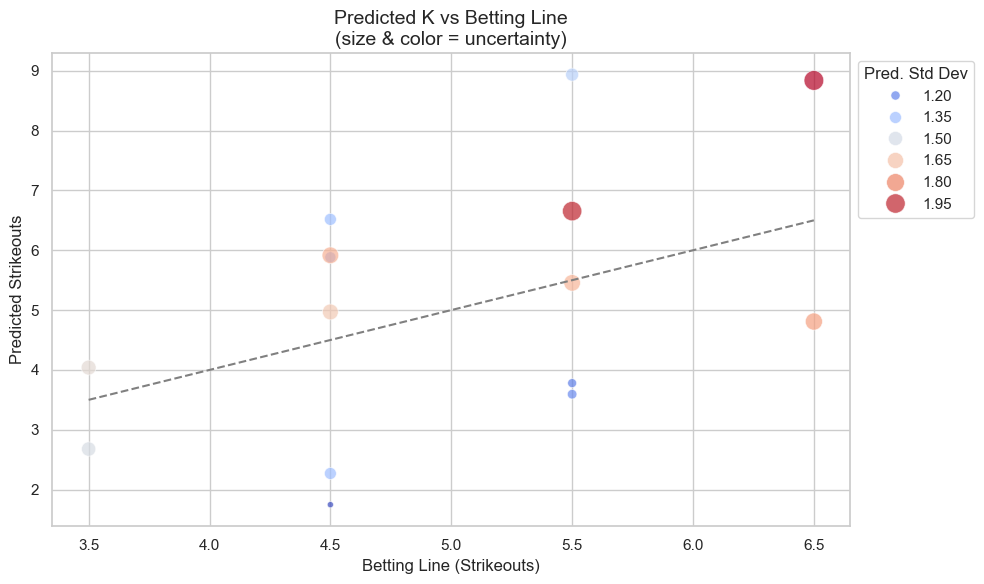

In [303]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='k_line', y='k_pred_mean', hue='hybrid_std', palette="coolwarm", size='hybrid_std', sizes=(20, 200), alpha=0.7)
plt.plot([merged['k_line'].min(), merged['k_line'].max()],
         [merged['k_line'].min(), merged['k_line'].max()], 'gray', linestyle='--')
plt.title('Predicted K vs Betting Line\n(size & color = uncertainty)', fontsize=14)
plt.xlabel('Betting Line (Strikeouts)')
plt.ylabel('Predicted Strikeouts')
plt.legend(title="Pred. Std Dev", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

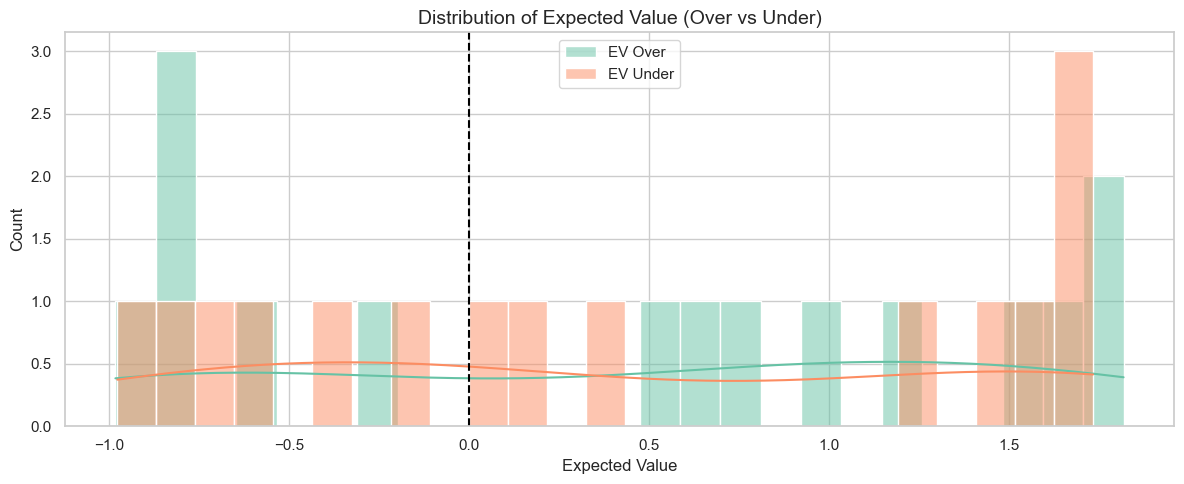

In [304]:
plt.figure(figsize=(12, 5))
sns.histplot(merged['ev_over'], kde=True, label='EV Over', color=colors[0], bins=25)
sns.histplot(merged['ev_under'], kde=True, label='EV Under', color=colors[1], bins=25)
plt.axvline(0, color='black', linestyle='--')
plt.title('Distribution of Expected Value (Over vs Under)', fontsize=14)
plt.xlabel('Expected Value')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/43/kb7838f9279bp0fk8kq0zm100000gn/T/ipykernel_63045/1581359070.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_ev, x='ev_over', y='pitcher_name', palette="Greens_d")


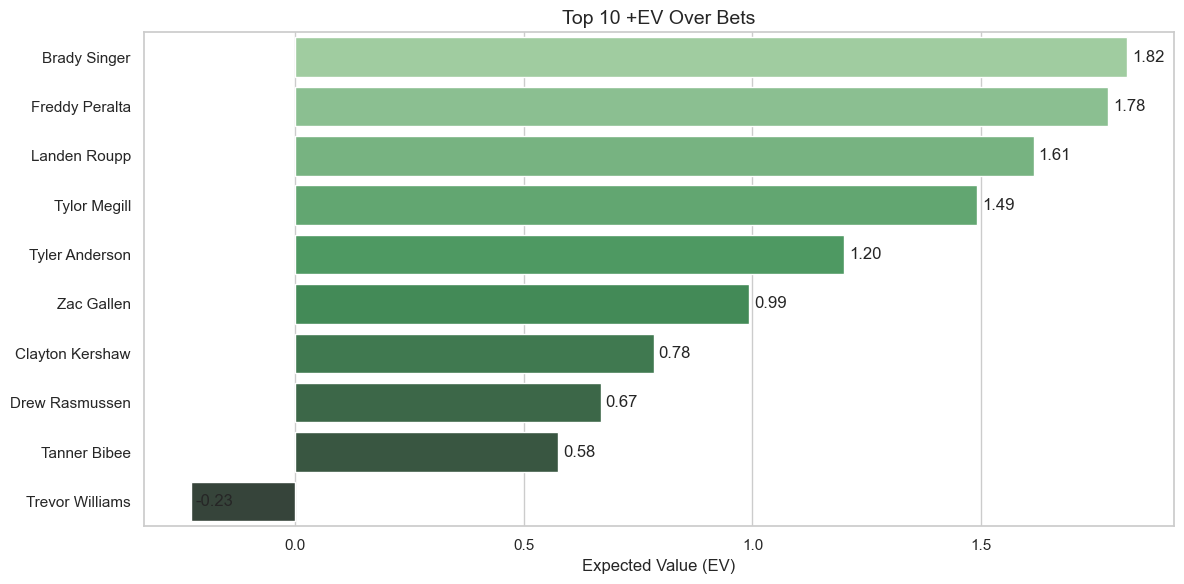

In [305]:
top_ev = merged.sort_values(by='ev_over', ascending=False).head(10)
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_ev, x='ev_over', y='pitcher_name', palette="Greens_d")
plt.title('Top 10 +EV Over Bets', fontsize=14)
plt.xlabel('Expected Value (EV)')
plt.ylabel('')
annotate_bars(ax)
plt.tight_layout()
plt.show()

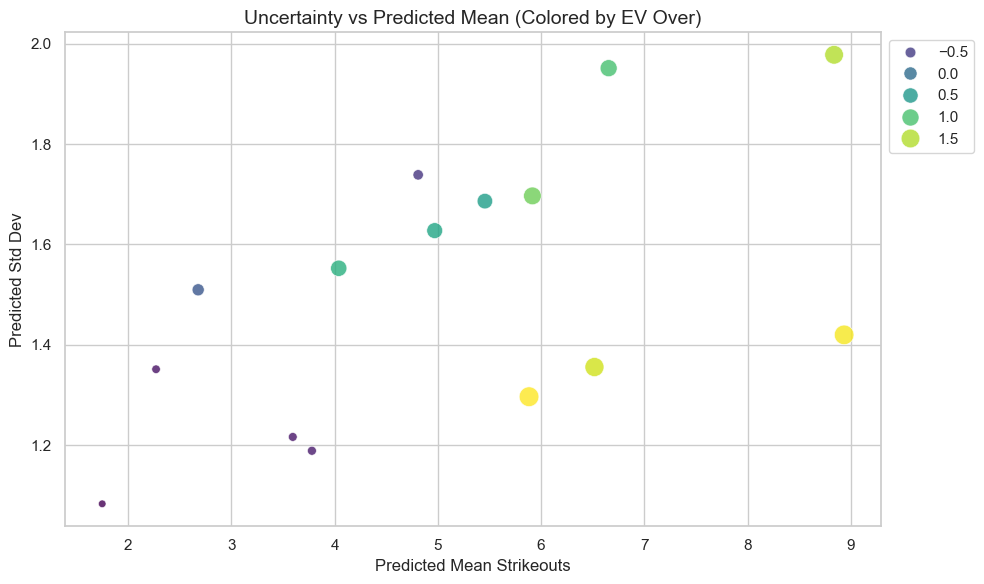

In [306]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='k_pred_mean', y='hybrid_std', hue='ev_over', size='ev_over', palette='viridis', sizes=(30, 200), alpha=0.8)
plt.title('Uncertainty vs Predicted Mean (Colored by EV Over)', fontsize=14)
plt.xlabel('Predicted Mean Strikeouts')
plt.ylabel('Predicted Std Dev')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [307]:
long_df = pd.concat([
    merged.rename(columns={
        "mc_ev_over": "ev", "payout_over": "payout"
    }).assign(play="over"),
    merged.rename(columns={
        "mc_ev_under": "ev", "payout_under": "payout"
    }).assign(play="under"),
], ignore_index=True)

long_df = long_df[long_df['ev'] > 0].sort_values('ev', ascending=False).reset_index(drop=True)
long_df[['pitcher_name', 'play', 'mc_p_over', 'mc_p_under']].head(25)

,pitcher_name,play,mc_p_over,mc_p_under
0,Brady Singer,over,0.805065,0.194935
1,Freddy Peralta,over,0.918795,0.081205
2,Jack Flaherty,under,0.139430,0.860570
3,Bowden Francis,under,0.115035,0.884965
4,Spencer Strider,under,0.216100,0.783900
5,Michael Lorenzen,under,0.078570,0.921430
6,Landen Roupp,over,0.868560,0.131440
7,Tylor Megill,over,0.827590,0.172410
8,Joe Ryan,under,0.125320,0.874680
9,Trevor Williams,under,0.322860,0.677140


In [308]:
from itertools import combinations

def generate_slips(df, slip_size=2):
    payout_table = {2: 3, 3: 6, 4: 10, 5: 20, 6: 35, 7: 65, 8: 120}
    slips = []

    for combo in combinations(df.itertuples(index=False), slip_size):
        if len(set(x.pitcher_name for x in combo)) < slip_size:
            continue
        probs = [(x.mc_p_over if x.play == "over" else x.mc_p_under) for x in combo]
        p_win = float(np.prod(probs))
        payout = payout_table.get(slip_size, 0)

        if payout == 0 or p_win == 0:
            continue

        total_ev = p_win * payout - 1

        legs = [{
            "pitcher": x.pitcher_name,
            "play": x.play,
            "ev": x.ev,
            "payout": x.payout,
            "k_line": x.k_line,
            "pitcher_team": x.pitcher_team
        } for x in combo]

        slips.append({
            "legs": legs,
            "avg_ev": total_ev / slip_size,
            "total_ev": total_ev,
            "slip_size": slip_size,
            "p_win": p_win,
            "payout": payout,
        })

    return slips

In [309]:
all_slips = []
for size in range(2, 9):
    all_slips += generate_slips(long_df.head(12), slip_size=size)

top_slips = sorted(all_slips, key=lambda x: x['total_ev'], reverse=True)

In [310]:
def filter_diverse_slips(slips, max_shared_legs=3):
    filtered = []
    seen = []

    for slip in slips:
        leg_ids = set((leg["pitcher"], leg["play"]) for leg in slip['legs'])
        if any(len(leg_ids & s) > max_shared_legs for s in seen):
            continue
        seen.append(leg_ids)
        filtered.append(slip)
    return filtered

fullsend_diverse = filter_diverse_slips(top_slips)

In [311]:
conservative_candidates = generate_slips(long_df.head(12), slip_size=2)
conservative_diverse = filter_diverse_slips(conservative_candidates)

In [313]:
from pprint import pprint

bankroll = 143
max_daily =  0.05 * bankroll
unit_size = 1
max_bet = max_daily

conservative_slips = []
spent = 0

for slip in conservative_diverse:
    if len(conservative_slips) >=3 or spent + unit_size > max_daily:
        break
    slip['units'] = 1
    conservative_slips.append(slip)
    spent += unit_size

print("Conservative Slips (3 x 2-leg):")
pprint(conservative_slips)
json.dump(conservative_slips, open("../betslips/ud_slips_2025-06-08_cons.json", "w"), indent=2)

fullsend_slips = []
spent = 0

for slip in fullsend_diverse:
    if spent >= max_daily:
        break

    units = 1
    if slip["total_ev"] > 1.5 and slip["p_win"] > 0.5:
        units = min(int(max_bet), 5)
    elif slip["total_ev"] > 1.0 and slip["p_win"] > 0.4:
        units = 2

    cost = units * unit_size
    if spent + cost <= max_daily:
        fullsend_slips.append({**slip, "units": units})
        spent += cost

json.dump(fullsend_slips, open("../betslips/ud_slips_2025-06-08_fullsend.json", "w"), indent=2)

print("Fullsend Slips (3+ legs):")
pprint(fullsend_slips)

Conservative Slips (3 x 2-leg):
[{'avg_ev': 0.6095345450125,
  'legs': [{'ev': 1.6486638499999997,
            'k_line': 4.5,
            'payout': 2.29,
            'pitcher': 'Brady Singer',
            'pitcher_team': 'CIN',
            'play': 'over'},
           {'ev': 1.572626,
            'k_line': 5.5,
            'payout': 1.8,
            'pitcher': 'Freddy Peralta',
            'pitcher_team': 'MIL',
            'play': 'over'}],
  'p_win': 0.739689696675,
  'payout': 3,
  'slip_size': 2,
  'total_ev': 1.219069090025,
  'units': 1},
 {'avg_ev': 0.5392221805749999,
  'legs': [{'ev': 1.6486638499999997,
            'k_line': 4.5,
            'payout': 2.29,
            'pitcher': 'Brady Singer',
            'pitcher_team': 'CIN',
            'play': 'over'},
           {'ev': 1.5407304761904763,
            'k_line': 5.5,
            'payout': 1.9523809523809523,
            'pitcher': 'Jack Flaherty',
            'pitcher_team': 'DET',
            'play': 'under'}],
  'p_win'